<span style="font-family:Papyrus; font-size:3em;" >Estimating Parameter Confidence Intervals With Bootstrapping</span>

This notebook demonstrates the calculations required to do confidence interval constructions.
1. Construct a good model. This means checking that we get good $R^2$ values (or other model quality metrics) for each fold in a cross validation.
1. Compute residuals for the good model.
1. Construct a collection of parameter estimates. That is, for many repetitions
   1. Construct new observations (by using randomly selected residuals)
   1. Estimate parameter values
1. Compute the mean and standard deviation of the parameter estimates
1. Construct the confidence interval

**SOME BUGS**

# Programming Preliminaries

In [1]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install matplotlib
  !pip install numpy
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIRS = ["/home/ubuntu/advancing-biomedical-models/common"]
    CODE_DIRS.append("/home/ubuntu/SBstoat")
    DATA_DIR = "/home/ubuntu/advancing-biomedical-models/lecture_12"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIRS = ["/content/drive/MyDrive/Modeling_Class/Winter 2021/common"]
    DATA_DIR = "/content/drive/MyDrive/Modeling_Class/Lecture Notes/12_lecture"
import sys
for path in CODE_DIRS:
    sys.path.insert(0, path)
# Other constants
TIME = "time"

In [2]:
%matplotlib inline
import numpy as np
import lmfit   # Fitting lib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from SBstoat.modelFitter import ModelFitter
from SBstoat.observationSynthesizer import ObservationSynthesizerRandomizedResiduals, ObservationSynthesizerRandomErrors
from SBstoat.namedTimeseries import NamedTimeseries
import model_fitting as mf

# Model and Data

In [3]:
# Model used in this example
MODEL = """
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""
PARAMETERS_TO_FIT = ["k1", "k2"]
PARAMETER_ESTIMATES = ModelFitter.mkParameters(parametersToFit=PARAMETERS_TO_FIT)
PARAMETER_ESTIMATES

name,value,initial value,min,max,vary
k1,5.00000000,5.0,0.00000000,10.0000000,True
k2,5.00000000,5.0,0.00000000,10.0000000,True


In [28]:
# Globals
NUM_POINTS = 30
SIM_TIME= 30
NOISE_STD = 0.3

In [29]:
fittedTS = ModelFitter.runSimulation(roadrunner=MODEL, numPoint=NUM_POINTS, endTime=SIM_TIME, returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NOISE_STD)
OBS_TS = synthesizer.calculate()
OBS_TS

                  A         B         C
time                                   
0.000000   5.026214  0.096980  0.233519
1.034483   4.929909  0.717475  0.099611
2.068966   4.054224  0.535628  0.489592
3.103448   3.215071  1.237469  0.395731
4.137931   3.169161  1.647774  0.972980
5.172414   3.819261  0.875364 -0.058998
6.206897   3.048047  1.249333  1.513524
7.241379   2.787148  1.038012  1.801140
8.275862   2.332460  1.744893  1.323397
9.310345   2.365980  1.105612  1.798313
10.344828  2.008223  1.285173  1.901395
11.379310  1.228176  1.146790  2.407820
12.413793  1.380282  0.721072  3.068548
13.448276  1.357885  1.670652  3.071982
14.482759  1.498346  1.321961  2.436897
15.517241  1.034296  0.836646  2.954669
16.551724  0.822259  0.997360  3.248405
17.586207  0.831416  0.612855  3.378325
18.620690  0.968184  0.839808  3.550553
19.655172  0.623036  0.867585  3.350565
20.689655  0.054722  0.692945  3.610196
21.724138  0.729664  0.902832  3.904983
22.758621  0.459937  0.573920  3.804113


In [30]:
def plotData(observedTS):
    """
    Creates a scatter plot of the observed data.
    
    Parameters
    ----------
    observedTS: NamedTimeseries
    
    Returns
    -------
    
    """
    figure, ax = plt.subplots(1)
    for column in observedTS.colnames:
        _ = ax.scatter(observedTS[TIME], observedTS[column])
    _ = plt.legend(observedTS.colnames)
    return figure
        
# Tests
figure = plotData(OBS_TS)
assert(isinstance(figure, matplotlib.figure.Figure))
_ = figure.clear()

<Figure size 432x288 with 0 Axes>

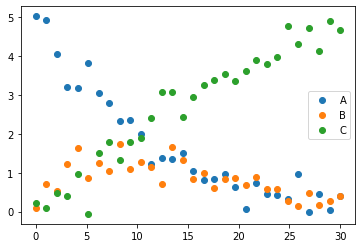

In [31]:
_ = plotData(OBS_TS)

# Bootstrapping Workflow

## Construct a good model.
In the following, we use the same model as the synthetic observations. Of course, in practice, you won't know the "true" model.

First, we need to estimate the parameter values to use in our model. To this end, we do a fit on the full set of data.

In [8]:
FITTER = ModelFitter(MODEL, OBS_TS, parametersToFit=["k1", "k2"])
FITTER.fitModel()
FITTED_TS = FITTER.fittedTS
PARAMETER_ESTIMATES = FITTER.params
PARAMETER_ESTIMATES

/home/ubuntu/advancing-biomedical-models/cls/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (30.000000000000004) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0.0, 30.000000000000004, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



name,value,standard error,relative error,initial value,min,max,vary
k1,0.09904200,0.00287913,(2.91%),7.729242718269962,0.00000000,10.0000000,True
k2,0.19764925,0.01059010,(5.36%),6.196442123419956,0.00000000,10.0000000,True


In [9]:
print(FITTER.reportFit())

[[Fit Statistics]]
    chi-square         = 6.85491241
    reduced chi-square = 0.07789673
    Akaike info crit   = -227.735972
    Bayesian info crit = -222.736353
[[Variables]]
    k1:  0.09904200 +/- 0.00287913 (2.91%) (init = 7.729243)
    k2:  0.19764925 +/- 0.01059010 (5.36%) (init = 6.196442)
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k2) = -0.400


**Question**
1. What are the parameter estimates if the NOSE_STD is 0.8?

## Compute the Residuals
Residuals need to be calculated by chemical species since they may be in very different units.

In [10]:
# Note that the residuals for the chemical species differ. Compare the residuals for A (1st col) with
# the residuals for C (3rd col)
columns = FITTED_TS.colnames
RESIDUALS_TS = OBS_TS.copy()  # Create the shape of the residuals
RESIDUALS_TS[columns] -= FITTED_TS[columns]
RESIDUALS_TS

                  A         B         C
time                                   
0.000000   0.344703 -0.370021 -0.378899
1.034483   0.128074 -0.194012 -0.060964
2.068966   0.305477 -0.101161 -0.078710
3.103448   0.040445 -0.391894  0.006478
4.137931   0.230517 -0.504015  0.166725
5.172414   0.167493 -0.032685 -0.443560
6.206897  -0.264987 -0.411991  0.116100
7.241379  -0.133502 -0.124189  0.296766
8.275862  -0.346631  0.717631 -0.510767
9.310345  -0.294313  0.185117 -0.046101
10.344828  0.225165  0.107663  0.040357
11.379310 -0.578471  0.187888  0.275717
12.413793  0.185901 -0.339562 -0.013100
13.448276 -0.220224 -0.057309 -0.292319
14.482759 -0.237955 -0.033963  0.163128
15.517241  0.184640 -0.218781  0.093884
16.551724 -0.190741 -0.421318 -0.299542
17.586207  0.078650 -0.055088 -0.081625
18.620690  0.175904 -0.140539 -0.236049
19.655172  0.040697 -0.311869  0.143414
20.689655  0.050580  0.257303 -0.268312
21.724138  0.334747  0.265075 -0.336475
22.758621 -0.517770 -0.077736  0.105998


In [11]:
# The standard deviation of the residuals should be approximately the same as the standard deviation
# of the random noise we injected in the construction of the observations.
np.std(RESIDUALS_TS.flatten())

0.2736503988421756

A validation of our codes and workflow is that the standard deviation of the residuals is close to the standard deviation of the noise used in the observational data.

## Construct a Collection of Parameter Estimates

### Step 3a: Construct Synthetic Observations
We define a function that constructs a set of observations from residuals and a model.

In [12]:
synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=FITTED_TS, observedTS=OBS_TS, residualsTS=RESIDUALS_TS)

In [13]:
synthesizer.calculate()

                  A         B         C
time                                   
0.000000   5.334747  0.158749 -0.510767
1.034483   4.688988 -0.064419 -0.289155
2.068966   4.152235  0.913844 -0.207578
3.103448   3.411899  0.918525 -0.029397
4.137931   3.185316  1.381921  0.485626
5.172414   2.804880  1.061572  0.520254
6.206897   2.879802  1.209231  0.716433
7.241379   2.249842  1.218347  1.605151
8.275862   2.318288  1.491571  1.226345
9.310345   1.768161  1.005697  1.433007
10.344828  1.556794  1.152228  2.105779
11.379310  1.740532  1.285211  1.771939
12.413793  1.328710  0.896297  2.422241
13.448276  1.129076  0.581770  2.645554
14.482759  1.496767  1.490372  3.174773
15.517241  1.242772  0.788872  3.085018
16.551724  0.750340  0.891908  2.801630
17.586207  0.996608  0.246814  3.131084
18.620690  0.841315  0.473584  3.594878
19.655172  0.764311  0.798783  3.626502
20.689655  0.349912  0.085197  4.068552
21.724138 -0.018885  0.175921  3.524130
22.758621  0.652935  0.723996  4.300619


In [14]:
# Try running this several times to see how values change.
synthesizer.calculate()

                  A         B         C
time                                   
0.000000   5.334747  0.717631  0.053208
1.034483   4.563664  1.020313  0.100529
2.068966   4.304102  0.913844  0.314734
3.103448   3.861526  1.238688  0.270792
4.137931   2.801048  0.724952  0.658220
5.172414   3.116182  1.144801  0.908267
6.206897   2.888538  1.428311  0.974198
7.241379   1.840210  0.881011  1.475109
8.275862   2.318288  1.015487  1.119260
9.310345   2.218901  0.695694  1.543594
10.344828  1.604008  1.409983  1.541803
11.379310  1.925448  1.256072  2.236606
12.413793  1.590287  1.004151  2.797718
13.448276  1.664521  0.661795  3.217425
14.482759  1.000548  0.497663  2.885956
15.517241  1.090717  1.004930  2.999831
16.551724  0.623933  0.280231  3.520908
17.586207  1.181525  1.077355  3.493280
18.620690  0.966639  0.667144  3.704798
19.655172  0.889635  0.579703  3.835731
20.689655  0.722875  0.251071  3.349275
21.724138  0.622185  0.481520  3.524130
22.758621  0.603511  0.370124  4.373699


### Repeatedly estimate parameter values

In [15]:
def estimateParameters(model, observedTS, parametersToFit, numIteration=10):
    estimateDct = {p: [] for p in parametersToFit}
    # Get the initial estimates
    fitter = ModelFitter(model, observedTS, parametersToFit=parametersToFit)
    fitter.fitModel()
    initialParams = fitter.params
    # Create the observation synthesizer
    synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=fitter.fittedTS, observedTS=observedTS)
    # Iterative calculate parameters
    for _ in range(numIteration):
        newObservedTS = synthesizer.calculate()
        newFitter = ModelFitter(model, newObservedTS, parametersToFit=parametersToFit)
        newFitter.fitModel(params=initialParams)
        [estimateDct[p].append(newFitter.params.valuesdict()[p]) for p in parametersToFit]
    return estimateDct

# Tests
numIteration = 5
estimateDct = estimateParameters(MODEL, OBS_TS, PARAMETERS_TO_FIT, numIteration=numIteration)
assert(len(estimateDct[PARAMETERS_TO_FIT[0]]) == len(estimateDct[PARAMETERS_TO_FIT[1]]))
assert(len(estimateDct[PARAMETERS_TO_FIT[0]]) == numIteration)

/home/ubuntu/advancing-biomedical-models/cls/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (30.000000000000004) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0.0, 30.000000000000004, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



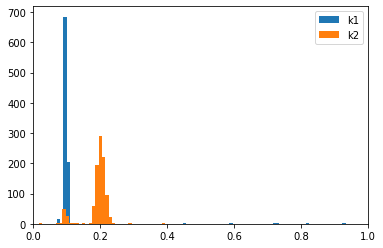

In [16]:
ESTIMATE_DCT = estimateParameters(MODEL, OBS_TS, PARAMETERS_TO_FIT, numIteration=1000)
def plotHist(parameter):
    _ = plt.hist(ESTIMATE_DCT[parameter],bins=1000)
    plt.xlim([0, 1])

for parameter in PARAMETERS_TO_FIT:
    plotHist(parameter)
_ = plt.legend(PARAMETERS_TO_FIT)

**Questions**
1. How do the quality of the parameter estimates change with the number of simulation points? With the simulation time?

## Compute Confidence Intervals

In [17]:
np.quantile(range(10), [.10, .90])

array([0.9, 8.1])

**Question**
1. Calculate 95% confidence intervals for the parameters.
   1. How many iterations should you use?

In [18]:
# Solution
for parameter in estimateDct.keys():
    quantile = np.quantile(estimateDct[parameter], [0.025, 0.975])
    print("%s: %s" % (parameter, str(quantile)))

k1: [0.09574023 0.10323049]
k2: [0.17541907 0.21321552]


**Questions**
1. Why does ``k1`` have such a wide confidence interval?

# Exercise

TRUE MODEL:

- A -> B
- A -> C
- B + C -> D

All kinetics are mass action. The kinetics constants are (in order of the reactions): 0.5, 0.5, 1.0. The initial concentration of A is 5. Consider a time course of duration 30 with 20 points.


1. Generate synthetic observations using this model using a normally distributed noise with a standard deviation
of 0.1.
1. Using the true model (the one above), find the $R^2$ values in a cross validation with 4 folds.
1. Construct confidence intervals for the parameters.

In [81]:
# Model used in this example
NEW_MODEL = """
     $A -> B; k1*$A
     $A -> C; k2*$A
     B + C -> $D; k3*B*C
     
     A = 5;
     B = 0;
     C = 0;
     D = 4;
     k1 = 0.49
     k2 = 0.5
     k3 = 1.3
"""

In [83]:
# Solution: Constants
NEW_NUM_POINT = 100
NEW_END_TIME = 30
NEW_NOISE_STD = 0.25

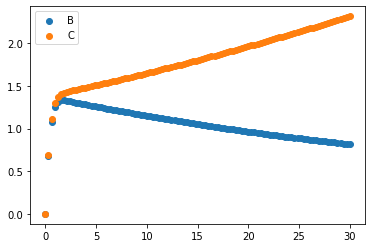

In [84]:
# Plot of the ground truth model
fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=0.0)
_ = plotData(synthesizer.calculate())

## Generate randomized observations

**Question**
1. Generate data with 100 points over 30 s and a stardard deviation of 0.25.

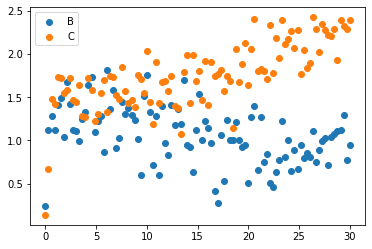

In [85]:
# Solution

fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NEW_NOISE_STD)
NEW_OBS_TS = synthesizer.calculate()
_ = plotData(NEW_OBS_TS)

**Questions**
1. For what part of these data will it be difficult to estimate the dynamics and therefore the kinetics constants?

## Construct a good fit of the model

## Estimate the residuals

## Construct bootstrap estimates

# Bootstrapping With SBstoat